In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

# Classificação por Limiar

Nesta aula vamos criar um classificador linear simples. Primeiramente apresento o conceito de características. Depois vamos explorar a relevância das características em relação a um atributo-alvo. Depois vamos discutir o conceito de *fronteira de decisão*. A seguir, vamos construir uma regra de classificação a partir da análise manual dos dados. Por fim, vamos analisar como encontrar o limiar de classificação automaticamente.

# A base de dados

A base de dados que vamos usar está em ``biometria.csv``. Ela contempla características físicas de vários jogadores de futebol e vôlei das seleções brasileiras de 2014. Nesta aula nosso objetivo é construir um classificador que decide o esporte que uma pessoa pratica a partir de suas características físicas.

In [4]:
df = pd.read_csv('biometria.csv')
df.replace('V', 'Vôlei',inplace=True)
df.replace('F', 'Futebol',inplace=True)
df.head()
#df

,Esporte,Altura (m),Peso (kg)
0,Vôlei,1.90,76
1,Vôlei,1.98,70
2,Vôlei,2.04,101
3,Vôlei,1.88,77
4,Vôlei,2.14,109


# Análise dos dados

Conhecer os dados é importante para projetar qualquer classificador. Esta análise serve para compreender a dificuldade do problema e possíveis métodos capazes de resolvê-lo.

Cada um dos elementos do conjunto de dados usado é caracterizado por três valores: o esporte que pratica (Futebol ou Vôlei), altura e peso. Chamamos cada dado utilizado para descrever algum objeto em um sistema de classificação, como *esporte*, *altura* e *peso*, de *característica*. No caso do problema que estamos tentando resolver, *altura* e *peso* são características de entrada, enquanto *esporte* é a característica de saída.

Visualizar todos esses dados na forma de uma tabela, porém, é claramente pouco prático. Podemos imaginar como conjuntos de dados ainda maiores se comportariam - uma tabela com jogadores de futebol e vôlei de todos os países que participam do campeonato mundial, por exemplo, seria obviamente muito grande para ser analisada na forma de números.

Uma análise inicial importante consiste no cálculo das estatísticas descritivas de cada característica, agrupando pela característica de saída (classe), neste caso, o esporte praticado.

In [5]:
df.groupby('Esporte').describe()

Altura (m)                                                       \
             count      mean       std   min    25%   50%     75%   max   
Esporte                                                                   
Futebol       23.0  1.813478  0.070878  1.63  1.765  1.81  1.8700  1.93   
Vôlei         22.0  1.986818  0.081497  1.85  1.925  1.98  2.0475  2.14   

        Peso (kg)                                                        
            count       mean        std   min    25%   50%   75%    max  
Esporte                                                                  
Futebol      23.0  75.000000   7.537784  60.0  69.50  76.0  79.5   88.0  
Vôlei        22.0  86.863636  10.273848  70.0  78.25  85.5  93.0  109.0

A partir das estatísticas calculadas para cada grupo, podemos verificar que a média da altura é bem diferente entre os jogadores de Futebol e Vôlei, sendo maior que 2 desvios-padrão (do Vôlei, que apresentou o maior desvio-padrão), o que sugere que estas 2 classes podem ser separadas linearmente pela característica altura. Analisando o peso médio entre os grupos também percebemos que há uma certa diferença, embora possívelmente não é estatisticamente significativa.

## Histograma

As características peso e altura são variáveis contínuas. Para compreender melhor a distribuição de uma característica podemos usar um histograma, que discretiza a distribuição dos valores em "baldes". Cada "balde" representa um intervalo dos valores e possui a contagem dos valores que estão naquele intervalo. Cada "balde" é representado por um gráfico de barras.

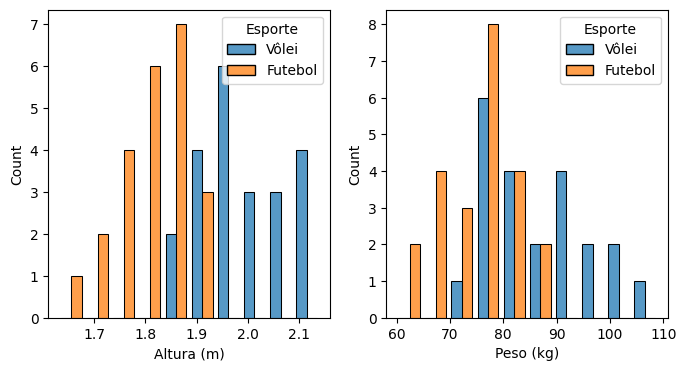

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
sns.histplot(data=df, bins=10, x='Altura (m)', hue='Esporte', multiple='dodge', shrink=0.8, ax=axes[0])
sns.histplot(data=df, bins=10, x='Peso (kg)', hue='Esporte', multiple='dodge', shrink=0.8,ax=axes[1])
plt.show()

O histograma da altura nos mostra que claramente a maioria dos jogadores de Futebol (em laranja) são mais baixos que os jogadores de Vôlei, embora haja alguns casos que esta observação não seja verdadeira. Entretanto, o histograma da característica peso mostra que embora os jogadores mais leves tendem a ser jogadores de Futebol e os mais pesados tendem a ser jogadores de Vôlei, há uma grande interseção dos dois grupos no intervalo entre 70 e 90kg, onde encontram-se a maior parte dos jogadores de ambos os esportes.

A partir destas observações, parece que a característica que separa melhor as duas classes é a altura.

## Scatterplot (gráfico de pontos)

Uma outra forma de conhecer o conjunto de dados é por meio de visualizações. Com estas ferramentas é possível ter uma idéia da separabilidade entre as classes e quais características que podem ser úteis para separá-las.

Como os objetos que queremos classificar tem apenas 2 características de entrada, é possível visualizá-los em um plano cartesiano 2D, onde cada característica é representada por um eixo coordenado. Para identificar cada ponto com sua classe podemos usar cores diferentes para cada uma.

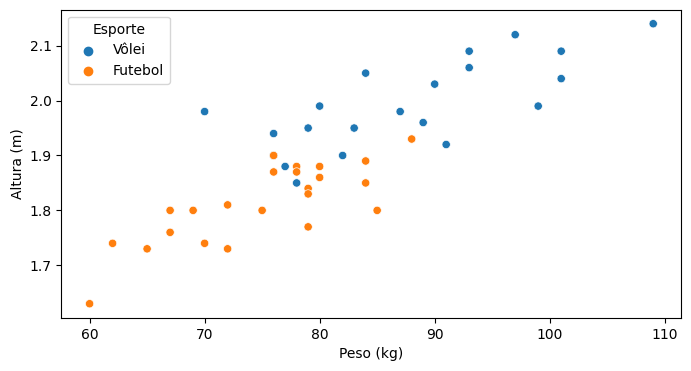

In [7]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x='Peso (kg)', y='Altura (m)', hue='Esporte')
plt.show()

Conforme esperado, podemos ver que a característica altura separa melhor as duas classes que queremos separar. Embora não dê para separar perfeitamente as 2 classes a partir da altura, podemos ver que é possível separar os 2 conjuntos razoavelmente bem traçando uma reta em ``altura=1,90``:

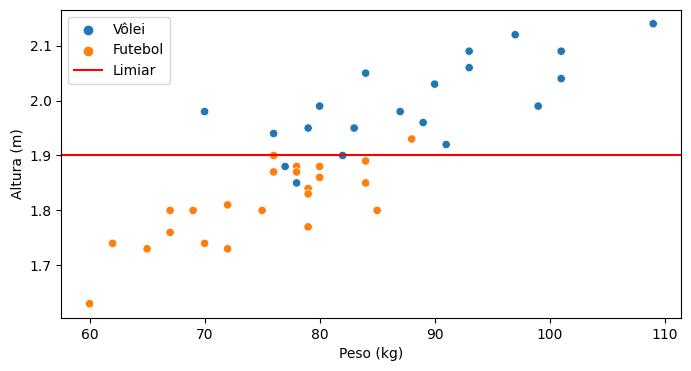

In [8]:
plt.figure(figsize=(8,4))
sns.scatterplot(data=df, x='Peso (kg)', y='Altura (m)', hue='Esporte')
plt.axhline(1.9, color='red', label='Limiar')
plt.legend()
plt.show()

O limiar *1,9* para a altura separa o espaço vetorial em duas regiões: o espaço que representa jogadores de futebol e o espaço que representa jogadores de Vôlei. Este valor não foi escolhido ao acaso: a idéia é encontrar o valor que **melhor separa** os dois conjuntos de pontos, ou seja, que minimize o erro de predição.

# Classificador

Um classificador pode ser modelado matematicamente como uma função n-dimendional cujos argumentos são as características e a saída é um rótulo. Dado $\mathbf{x} \in \mathbb{R}^n$, onde $n$ é o número de características, e $C = \{c_0, c_1, \dots, c_m\}$ um conjunto de rótulos,  um classificador é uma função:

$$f: \mathbb{R}^n \mapsto C$$

## Exemplo de classificador por limiar

No caso do problema que estamos trabalhando, $\mathbf{x} \in \mathbb{R}^2$, onde a primeira de dimensão de $\mathbf{x}$ é a altura do jogador, e a segunda é o peso. Note que **x** é um vetor, tal qual aquele estudado em álgebra linear. Distinguimos entre vetores e escalares escrevendo vetores em **negrito**. O conjunto dos rótulos $C$ é dado pelos 2 esportes que temos na base de dados: $C = ${Futebol, Vôlei}. Usando o limiar 1,9 para a característica *altura* e considerando o espaço visualizado no *scatterplot*, temos um classificador:

$$
f(\mathbf{x}) = 
\begin{cases}
    Futebol & \text{se } x[0] \leq 1,9 \\
    Volei   & \text{se } x[0] \gt 1,9
\end{cases}
$$

Note que este classificador utiliza apenas uma das 2 características (*altura*, que está na posição 0 do vetor **x**) para fazer a predição. Mais adiante iremos explorar como podemos combinar multiplas características.


In [9]:
def classificador_limiar(limiar, dados, rotulos=('Futebol', 'Vôlei')):
    resposta = []   
    for idx, dado in dados.iterrows():
        if dado[0] <= limiar:
            resposta.append(rotulos[0])
        else:
            resposta.append(rotulos[1])
    return pd.DataFrame(resposta, columns=['Esporte'])

#A implementação a seguir é mais eficiente e tem o mesmo resultado
# def classificador_limiar(limiar, dados, rotulos=('Futebol', 'Vôlei')):
#     def f(dado):
#         return rotulos[0] if dado[0] <= limiar else rotulos[1]
#     resposta = dados.apply(f, axis=1)
#     return resposta
    
    

In [10]:
predicoes = classificador_limiar(1.9, df[['Altura (m)', 'Peso (kg)']])
for p in predicoes.values.flatten():
    print(p, end=", ")

Futebol, Vôlei, Vôlei, Futebol, Vôlei, Vôlei, Vôlei, Vôlei, Vôlei, Vôlei, Vôlei, Vôlei, Vôlei, Futebol, Vôlei, Vôlei, Futebol, Vôlei, Vôlei, Vôlei, Vôlei, Futebol, Futebol, Futebol, Vôlei, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, Futebol, 

# Verificando o desempenho do classificador

É necessário medir o desempenho do classificador desenvolvido para ter uma idéia de sua assertividade.

In [11]:
#imprimir os esportes da base de dados, juntamente com as predições
predicoes = classificador_limiar(1.9, df[['Altura (m)', 'Peso (kg)']])
for i in np.vstack([df['Esporte'].values, predicoes['Esporte'].values]).T:
    print(i)

['Vôlei' 'Futebol']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Futebol']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Futebol']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Futebol']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Vôlei']
['Vôlei' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Vôlei']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']
['Futebol' 'Futebol']


## Acurácia

Existem muitas medidas de desempenho de classificadores. Estas medidas são comumente conhecidas como métricas. Uma das métricas mais simples e intuitivas de classificação é chamada de **acurácia**. A acurácia é dada por:

$$
    \text{Acurácia} = \frac{\text{acertos}}{\text{total de instâncias}}
$$

Para contabilizar o número de acertos é necessário conhecer o gabarito (*ground-truth*) dos resultados. No caso da base de dados de jogadores de futebol e vôlei, o gabarito é o esporte que sabemos que determinada pessoa pratica. A seguir, temos uma função

In [12]:
def comparar_resultados(predicoes, gabarito, rotulo):
    predicoes = predicoes.values
    gabarito = gabarito.values
    acertos = 0
    erros = 0
    for i, gab in enumerate(gabarito):
        if gab == rotulo:
            if gab == predicoes[i]:
                acertos+=1
            else:
                erros+=1
    return acertos, erros

In [13]:
resultados_futebol = comparar_resultados(predicoes['Esporte'], df['Esporte'], 'Futebol')
resultados_volei = comparar_resultados(predicoes['Esporte'], df['Esporte'], 'Vôlei')

print("(Futebol) Acertos e Erros:", resultados_futebol)
print("(Vôlei) Acertos e Erros:", resultados_volei)

(Futebol) Acertos e Erros: (22, 1)
(Vôlei) Acertos e Erros: (17, 5)


Nota-se que proporcionalmente o classificador acertou mais os jogadores de futebol do que os jogadores de vôlei. Agora vamos calcular a acurácia do classificador para cada classe separadamente, e depois para o classificador de um modo geral. A vantagem da acurácia é que vamos ter um único número que vai nos descrever cada um destes cenários.

In [14]:
def acuracia(acertos, total_instancias):
    return acertos / total_instancias

print("Acurácia (Futebol): %.3f" % (acuracia(resultados_futebol[0], resultados_futebol[0] + resultados_futebol[1]) ))
print("Acurácia (Vôlei): %.3f" % (acuracia(resultados_volei[0], resultados_volei[0] + resultados_volei[1]) ))
total_de_instancias = len(predicoes)
print("Acurácia (Total): %.3f" % (acuracia(resultados_futebol[0] + resultados_volei[0], total_de_instancias) ))

Acurácia (Futebol): 0.957
Acurácia (Vôlei): 0.773
Acurácia (Total): 0.867


In [15]:
# A biblioteca sklearn tem várias métricas implementadas que iremos estudar durante o curso.
from sklearn.metrics import accuracy_score
print("Acurácia (Total) %.3f" % (accuracy_score(df['Esporte'], predicoes['Esporte'])))

Acurácia (Total) 0.867


O desempenho do classificador é diretamente relacionado com seus parâmetros. No caso do exemplo, o parâmetro do classificador é o limiar. 

Nós decidimos um valor para este limiar com base nas observações dos dados. Como o parâmetro do classificador foi escolhido manualmente, não podemos dizer que houve aprendizado de máquina até aqui.

Qual é o papel da aprendizagem neste contexto? "Aprender" significa encontrar um limar cada vez melhor, ou seja, otimizar o limiar de forma que o classificador erre o mínimo possível considerando suas limitações.

# Aprendizado do limiar por busca exaustiva

O algoritmo de aprendizado mais simples realiza uma busca exaustiva pelos parâmetros que otimizem alguma métrica. Esta técnica se chama busca exaustiva, ou busca em grade (*grid-search*). No exemplo que estamos estudando, a busca exaustiva testa uma lista de todos os limiares possíveis dentro de um intervalo, e retorna o limiar que maximiza a métrica de desempenho (como a acurácia, por exemplo).

Melhor limiar: 1.891, Melhor Acurácia: 0.911


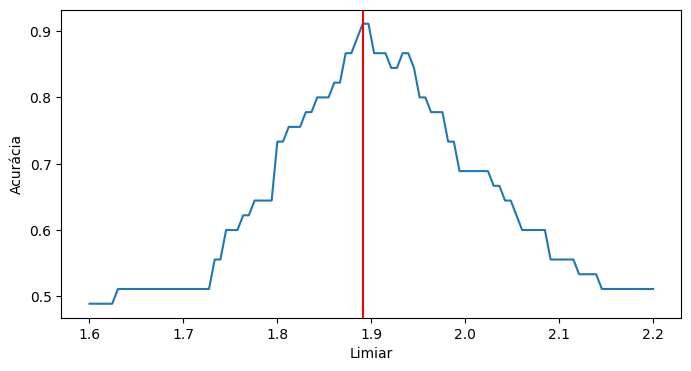

In [16]:
n_limiares = 100
limiares = np.linspace(1.6, 2.2, n_limiares)
acuracias = []

melhor_limiar = limiares[0]
melhor_acuracia = 0

dados = df[['Altura (m)', 'Peso (kg)']]

for limiar in limiares:
    predicoes = classificador_limiar(limiar, dados)
    
    acuracia = accuracy_score(df['Esporte'], predicoes['Esporte'])
    acuracias.append(acuracia)
    
    if acuracia > melhor_acuracia:
        melhor_acuracia = acuracia
        melhor_limiar = limiar

print("Melhor limiar: %.3f, Melhor Acurácia: %.3f" % (melhor_limiar, melhor_acuracia))

fig, axes = plt.subplots(figsize=(8,4))
axes.plot(limiares, acuracias)
axes.axvline(melhor_limiar, color='red')
axes.set_xlabel('Limiar')
axes.set_ylabel('Acurácia')
plt.show()

A busca exaustiva pode encontrar bons resultados, mas depende da realização da classificação muitas vezes. A quantidade de vezes aumenta proporcionalmente a quantidade de valores a serem avaliados. No exemplo, avaliamos ``n_limiares`` valores linearmente espaçados entre 1,6 e 2,2. Quanto maior ``n_limiares`` maior a probabilidade de encontrar a melhor solução possível (a solução ótima). Entretanto, o custo da busca aumenta proporcionalmente.

Esta abordagem na maioria das vezes não é viável, uma vez que os modelos usados na prática possuem muitos parâmetros que apenas um limiar. Com muitos parametros para otimizar em conjunto, o custo computacional aumenta exponencialmente, o que inviabiliza este método. O foco do nosso curso não é estudar os algoritmos de otimização, entretanto é importante compreender que existem técnicas mais eficientes para encontrar soluções que são viáveis, mas que nem sempre encontram a melhor solução possível.

# E a generalização?

<!-- Propositalmente deixei uma falha grave no método de avaliação do classificador.  -->

Quando um professor verifica se um aluno aprendeu um conteúdo, ao invés de apenas decorá-lo, avalia se o aluno é capaz de resolver um exercício parecido, mas que não foi explicitamente resolvido na sala de aula ou foi passado nas listas de exercícios. Isto porque **aprender é diferente de decorar**.

Um aprendizado bem-sucedido permite resolver problemas cujas soluções não foram explicitamente mostradas anteriormente. Em outras palavras, o aprendizado bem-sucedido implica em **generalização**.

A avaliação da classificação que fizemos nesta aula não avalia a generalização. Portanto, não há garantia que este classificador será suficientemente robusto para classificar **dados de jogadores que não foram usados no processo de aprendizagem**. Na próxima aula vamos estudar como podemos avaliar a capacidade de generalização de um classificador.



In [17]:
from sklearn.neighbors import KNeighborsClassifier


def classificador_knn(n_neighbors, x_treino, y_treino, x_teste):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(x_treino, y_treino)
    predicoes = knn.predict(x_teste)
    return predicoes

In [21]:
def classificador(n_limiares, x_treino, y_treino, coluna, ks, df=df):
    limiares = np.linspace(df[coluna].min(), df[coluna].max(), n_limiares)
    acuracias = []
    
    melhor_limiar = limiares[0]
    melhor_acuracia = 0
    melhor_k = 0
    
    for limiar in limiares:
        melhor_acuracia_k = 0
        
        for k in ks:
            predicoes = classificador_knn(k, x_treino, y_treino, x_treino)
        
            acuracia = accuracy_score(y_treino, predicoes)
        
            if acuracia > melhor_acuracia:
                melhor_acuracia = acuracia
                melhor_limiar = limiar
                melhor_k = k
        acuracias.append(melhor_acuracia_k)
    
    return melhor_limiar, melhor_acuracia, melhor_k

In [26]:
x_treino, x_teste, y_treino, y_teste = train_test_split(df[['Altura (m)', 'Peso (kg)']], df['Esporte'], test_size=0.2, random_state=42)
ks = list(range(1,30,2))
melhor_limiar, melhor_acuracia, melhor_k = classificador(100, x_treino, y_treino, 'Altura (m)',ks)

print("Melhor limiar (knn): %.3f, Melhor Acurácia (knn): %.3f, melhor k %i" % (melhor_limiar, melhor_acuracia, melhor_k))

Melhor limiar (knn): 1.630, Melhor Acurácia (knn): 0.778, melhor k 2


In [52]:
limiar, acc


(1.63, 0)